In [7]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 가설검정 및 통계 분석 패키지
from scipy import stats

# 선형모델 formula ( y ~ x1 + x2 + ...)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scale변환 -> 표준화 회귀계수 산출
## coefficient를 표준화해서 비교해본다.
from sklearn.preprocessing import StandardScaler

# grhpviz
from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

# 앙상블 모델
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import GridSearchCV


# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

# 폰트 설정
matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [5]:
df_raw = pd.read_csv("./Data/체질검사.csv")

df_raw_y = df_raw["FAT"]
df_raw_x = df_raw.drop("FAT", axis=1, inplace = False)

- train_test_split (7:3으로 트레인과 테스트 데이터가 나눠진다.)

In [6]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (176, 13)
train data Y size: (176,)
test data X size: (76, 13)
test data Y size: (76,)


# RandomForeset

In [1]:
rf_uncustomized = RFR(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

NameError: name 'RFR' is not defined

※ test데이터의 설명력이 상대적으로 낮음: 과대적합

## 2. 파라미터 변경

- n_estimators: 트리 수 변경에 따른 모델 성능

In [10]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state=1234, n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["n_estimators"] = para_n_tree
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [13]:
df_score_leaf.round(3)

# Train과 Test Score의 Gap이 크다면 모델이 불안정한 것으로 볼 수 있다.

,n_estimators,TrainScore,TestScore
0,10,0.936,0.542
1,20,0.946,0.597
2,30,0.952,0.610
3,40,0.955,0.609
4,50,0.955,0.611
5,60,0.956,0.616
6,70,0.955,0.614
7,80,0.955,0.611
8,90,0.956,0.610
9,100,0.956,0.612


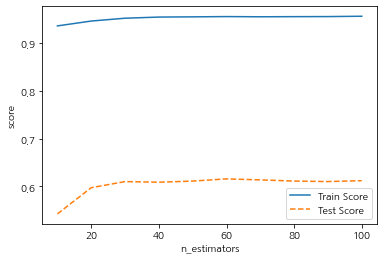

In [14]:
plt.plot(para_n_tree, train_score, linestyle="-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle="--", label = "Test Score")
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.legend()

- min_samples_leaf: 잎사귀 노드의 최소 자료 수

In [15]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(random_state=1234, n_estimators = 100, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [18]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.956,0.612
1,2,0.939,0.610
2,3,0.915,0.611
3,4,0.891,0.617
4,5,0.869,0.622
5,6,0.849,0.627
6,7,0.830,0.626
7,8,0.816,0.621
8,9,0.800,0.619
9,10,0.786,0.619


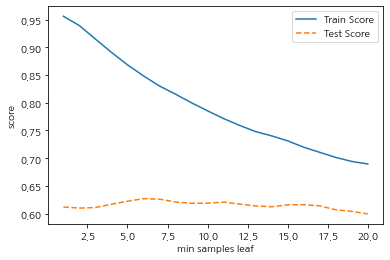

In [19]:
plt.plot(para_leaf, train_score, linestyle="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label = "Test Score")
plt.xlabel("min samples leaf")
plt.ylabel("score")
plt.legend()


- 6정도에서 가장 괜찮아 보인다.

- min_samples_split: 분리 노드의 최소 자료 수 변경

In [21]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RFR(random_state=1234, n_estimators = 100, min_samples_leaf = 6, 
             min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [22]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.849,0.627
1,6,0.849,0.627
2,8,0.849,0.627
3,10,0.849,0.627
4,12,0.849,0.627
5,14,0.839,0.629
6,16,0.831,0.629
7,18,0.821,0.628
8,20,0.813,0.628
9,22,0.803,0.628


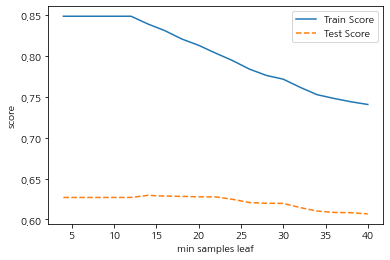

In [24]:
plt.plot(para_split, train_score, linestyle="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle="--", label = "Test Score")
plt.xlabel("min samples leaf")
plt.ylabel("score")
plt.legend()

※ 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소한다.  따라서 데이터의 성능변화를 고려해 13~14정도를 선정한다.

- MaxDepth: 최대 깊이 변경에 따른 모델 성능

In [25]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RFR(random_state=1234, n_estimators = 100, min_samples_leaf = 6, 
             min_samples_split=13, max_depth=v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["Maxdepth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [26]:
# 모델 설명력 확인
df_score_leaf.round(3)

,Maxdepth,TrainScore,TestScore
0,1,0.557,0.448
1,2,0.721,0.598
2,3,0.790,0.619
3,4,0.828,0.627
4,5,0.842,0.630
5,6,0.844,0.629
6,7,0.844,0.630
7,8,0.844,0.630
8,9,0.844,0.630
9,10,0.844,0.630


In [2]:
plt.plot(para_depth, train_score, linestyle="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle="--", label = "Test Score")
plt.xlabel("Max Depth")
plt.ylabel("score")
plt.legend()

NameError: name 'plt' is not defined

※ 4정도로 가져가면 좋아 보인다.

## 3. 결론 도출

In [28]:
rf_final = RFR(random_state=1234, n_estimators = 100, min_samples_leaf = 6, 
             min_samples_split=13, max_depth=4)
rf_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.828
Score on test set: 0.627


※ 파라미터 튜닝 전과 test셋이 0.015차이가 난다.

- 트리를 그려서 확인

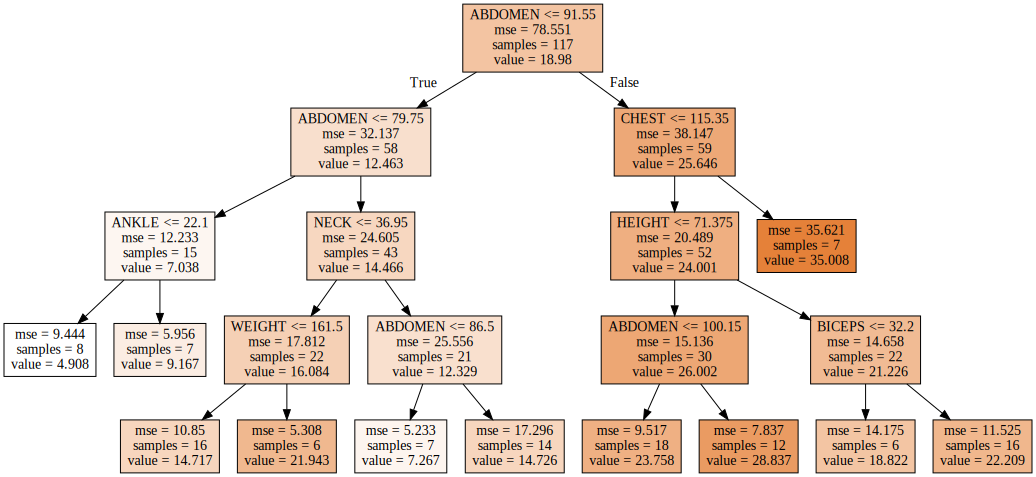

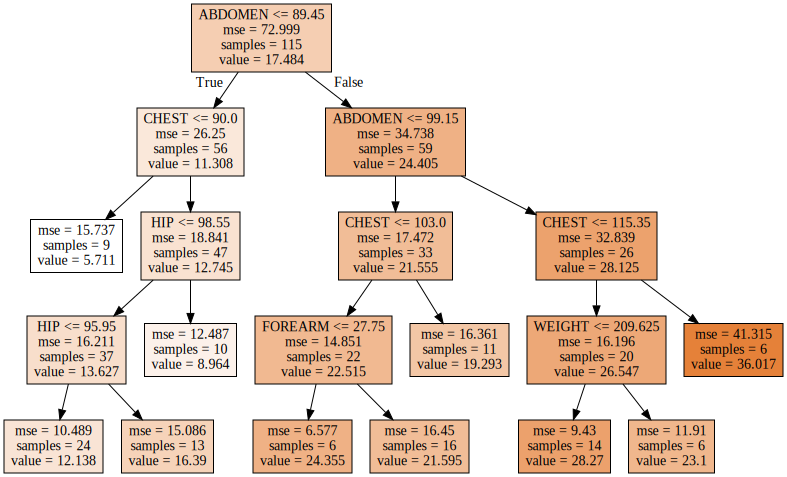

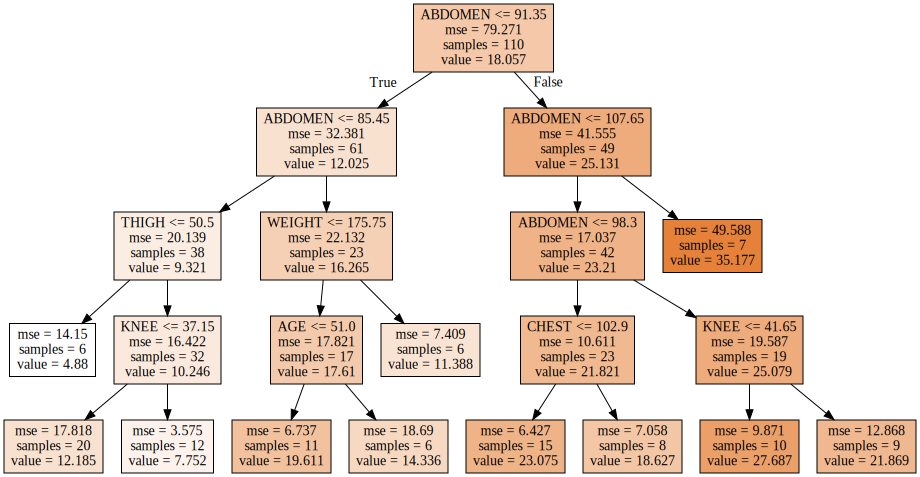

In [29]:
v_feature_name = df_train_x.columns

# 0번 트리-----------------------------
export_graphviz(rf_final.estimators_[0], out_file = "rfr_final_0.dot",
               feature_names = v_feature_name,
               impurity=True, filled=True)

# tree_final_0.dot 그리기
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 1번 트리-----------------------------
export_graphviz(rf_final.estimators_[1], out_file = "rfr_final_0.dot",
               feature_names = v_feature_name,
               impurity=True, filled=True)

# tree_final_1.dot 그리기
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 10번 트리-----------------------------
export_graphviz(rf_final.estimators_[10], out_file = "rfr_final_0.dot",
               feature_names = v_feature_name,
               impurity=True, filled=True)

# tree_final_10.dot 그리기
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

※ 위와 같은 트리 100개를 조합하여 최종 모델이 생성되는 것이다.

## 4. 결론 도출_설명변수 중요도
- feature_importances_: 설명변수의 중요도

In [30]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = rf_final.feature_importances_


df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.839
4,CHEST,0.037
2,HEIGHT,0.033
0,AGE,0.015
6,HIP,0.014
7,THIGH,0.012
12,WRIST,0.011
3,NECK,0.011
8,KNEE,0.009
1,WEIGHT,0.008


Text(0, 0.5, '변수(feature)')

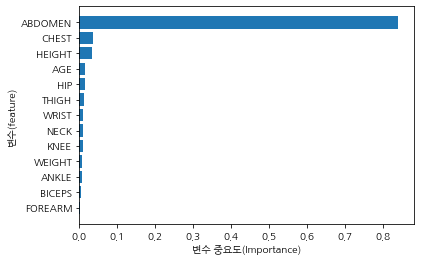

In [32]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도(Importance)")
plt.ylabel("변수(feature)")

- 앙상블 RF모델로 변경한 이후 중요도의 순사가 바뀌게 되었다.
- 또한 다른 변수들의 중요도도 0인 경우가 많이 줄어들게 되었다.